In [53]:
import pandas as pd 
DATASET = "amazon_reviews_us_Grocery_v1_00.tsv"
BR_DATASET = "bad-reviews.csv"
ENTRIES_WANTED = 10000
import logging
import warnings
import sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import random
import math
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
logging.disable(sys.maxsize)



In [3]:
dataset = pd.read_table(DATASET, error_bad_lines=False, header=0, warn_bad_lines=False) 
# there are some malformed entries the dataset... let's ignore those for now


In [4]:
### Let's see what the dataset looks like... 
dataset.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nu...",2015-08-31
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and ...",2015-08-31
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend l...,2015-08-31
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great sec...,2015-08-31
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31


In [5]:
#lots of nan values... :( 
dataset.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating          22
helpful_votes        23
total_votes          23
vine                 23
verified_purchase    23
review_headline      34
review_body          88
review_date          65
dtype: int64

In [6]:
# Lots of spammy duplicate reviews...might be worth checking if the same person is duplicating the reviews across multiple products

# Additions, because maybe same review_body is not duplicate i.e. "Good" as review.
x = dataset[dataset['review_body'].duplicated() == True]
x = x[dataset['customer_id'].duplicated() == True] # ADDED THIS
x = x[dataset['product_id'].duplicated() == True] # ADDED THIS
print(len(x))
x.head()

75144


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2323,US,32433311,R3DPQJFH05T0HS,B00OZYNGUS,228095196,Viva Naturals - The FINEST Raw Organic Chia Se...,Grocery,5,0.0,0.0,N,Y,Great product.,I've been using this to help keep me from snac...,2015-08-31
2330,US,130585,R3IOACXWPYTRUP,B00HZ7HSTW,885171844,Beantown Roasters K Cups Variety Packs,Grocery,5,0.0,1.0,N,Y,The Office like it!,These were purchased for an office and they lo...,2015-08-31
2401,US,14100648,RA8F0DF5OJH3J,B000WV0RW8,653213046,Healthworks Chia Seeds 3lb 6lb Parent,Grocery,5,0.0,0.0,N,Y,GREAT! Thanks So much and God bless,GREAT! Thanks So much and God bless! &#60;&#...,2015-08-31
2436,US,43554935,RK0TC9FRNUL55,B00HQ3ZPJA,220133938,Chia Seeds,Grocery,5,0.0,0.0,N,Y,Five Stars,As advertised.,2015-08-31
2541,US,168472,R2WFNGP0E0ZLXW,B006ZMYLKC,322601427,Keurig,Grocery,5,0.0,0.0,N,Y,Five Stars,Satisfied,2015-08-31


In [7]:
#remove NaNs from the dataset  for now...
dataset = dataset.dropna()

In [8]:
def filter_heuristic(row):
    '''
    determine if a row is a negative review based on its score. Potentially extend it to include sentiment analysis 
    and presence of specific negative words 
    '''
    return row["star_rating"].astype(int) <=3

In [9]:
negative_rows = dataset.loc[filter_heuristic]
negative_rows.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
5,US,23649464,RIG9AWFOGRDVO,B00AL6QBZ6,681475449,Herr's Popcorn Hot Cheese 1 Oz (Pack of 30),Grocery,2,1.0,1.0,N,Y,Not Happy,The popcorn was stale.,2015-08-31
9,US,19624355,R1ODXB3C9UP3NL,B00J074W94,2499702,"Orgain Organic Plant Based Protein Powder, Pac...",Grocery,1,1.0,3.0,N,N,Disgusting now and difficult on digestion,Used to be a decent product. Disgusting now a...,2015-08-31
17,US,22765168,R3T6TTD2IN0EFZ,B00XDXMLL2,971154239,"Skippy Creamy Peanut Butter, with Salted Caram...",Grocery,1,4.0,4.0,N,N,"1 Out Of 5 Of My Co-Workers Thought It Was ""Okay""",I bought this from a local super market on a w...,2015-08-31
23,US,35636887,R9MISLBRG08FX,B00DBSFXUA,294404974,"Keebler Town House Pita Crackers, 9.5 Ounce",Grocery,1,0.0,0.0,N,Y,pita crackers,not craze about these. nothing really wrong wi...,2015-08-31
26,US,12650237,R2A9O8CWZ1PP74,B0083GJKR2,868929824,"Eclipse Sugar Free Gum, Spearmint, 120 Piece B...",Grocery,3,0.0,0.0,N,Y,Three Stars,it's gum..,2015-08-31


In [10]:
sorted_negative_rows = negative_rows.sort_values("product_id")
sorted_negative_rows.head() # ADDITION JUST TO CHECK

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1975011,US,14434517,R25ATZCV5FBJMV,0805470867,518591127,Communion Bread Pack of 500,Grocery,2,3.0,4.0,N,Y,The only thing my church has ever complained a...,I'm the pastor of a church plant and the only ...,2012-10-16
1365978,US,47145,RUI9CRY6RZNRB,0805470867,518591127,Communion Bread Pack of 500,Grocery,1.0,0.0,0.0,N,Y,I HATE IT,what is that thing<br />it doesn't crunch like...,2014-02-21
1961839,US,37403535,R37YYRMOE7K2TB,0805470867,518591127,Communion Bread Pack of 500,Grocery,1,1.0,1.0,N,Y,Communion bread,"I purchased 3 boxes, two of them the experatio...",2012-11-11
78777,US,41394716,R2QAW3WQRYVQF5,0805470867,518591127,Communion Bread Pack of 500,Grocery,3,0.0,0.0,N,Y,Not what expected,"This came in a flimsy cardboard box, squished....",2015-08-04
1845770,US,11312642,R3M9ORU1I9L2C3,0805470867,518591127,Communion Bread Pack of 500,Grocery,2,0.0,0.0,N,Y,Gross,These things taste nothing like the communion ...,2013-02-18


In [11]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width = 5000, height = 5000, random_state=1, background_color='salmon', colormap='Pastel1',
                          collocations=False, stopwords = STOPWORDS).generate(text)
    plt.imshow(wordcloud)

In [12]:
# generate a naive word cloud without any preprocessing....
# generate_wordcloud(" ".join(sorted_negative_rows["review_body"]))

In [13]:
sorted_rows = dataset.sort_values("product_id")
sorted_rows["avg_rating"] = ""
sorted_rows.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,avg_rating
115213,US,886579,R18D9WDJHHZNWA,0268956898,674048074,Delgada coffee infused with Chaga 28 Sachets p...,Grocery,5,7.0,8.0,N,N,You will lose weight and feel great..,This coffee has been a life saver for me.. I s...,2015-07-22,
1569777,US,41921418,R1QUUN8C0ZF7C7,0657745316,31867226,100 Percent All Natural Vanilla Extract,Grocery,5,1.0,1.0,N,N,Best vanilla I've ever had,"No sugar, no GMO garbage, no fillers that come...",2013-10-11,
1299951,US,20405919,R105NG5PE8CMHK,0681727810,680395208,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Grocery,5,4.0,4.0,N,Y,"This cheese is so good, just wish it didn't co...","This cheese is so good, just wish it didn't co...",2014-04-01,
1941826,US,36034133,R26D6HKBPP95HB,0700026444,597586824,Pure Darjeeling Tea: Loose Leaf,Grocery,5,2.0,2.0,N,N,Terrific Tea!,"This is my absolute, undisputed favorite tea r...",2012-12-06,
715823,US,50510678,R440L1BV7SZ18,0786960159,449320317,Axis and Allies 1942 Second Edition: A Wwii St...,Grocery,5,0.0,0.0,N,Y,Five Stars,1st class,2015-01-05,


In [14]:
starRating = sorted_rows.iloc[0]["star_rating"]
productId = sorted_rows.iloc[0]["product_id"]
print(len(sorted_rows))

i = 0

while i < len(sorted_rows):
    productId = sorted_rows.iloc[i]["product_id"]
    sum = 0
    skip = 1

    sum += int(sorted_rows.iloc[i]["star_rating"])

    sameProduct = True

    while(sameProduct):
        if((i + skip) == len(sorted_rows)):
            sameProduct = False
        elif(sorted_rows.iloc[i + skip]["product_id"] == productId):
            sum += int(sorted_rows.iloc[i + skip]["star_rating"])
            skip += 1
        else:
            sameProduct = False

    avgRating = round((sum / skip), 2)

    for j in range(skip):
        sorted_rows.iat[(i + j),15] = avgRating
    
    i += 1
    i += (skip - 1)

sorted_rows.head(25)


2393238


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,avg_rating
115213,US,886579,R18D9WDJHHZNWA,0268956898,674048074,Delgada coffee infused with Chaga 28 Sachets p...,Grocery,5,7.0,8.0,N,N,You will lose weight and feel great..,This coffee has been a life saver for me.. I s...,2015-07-22,5.0
1569777,US,41921418,R1QUUN8C0ZF7C7,0657745316,31867226,100 Percent All Natural Vanilla Extract,Grocery,5,1.0,1.0,N,N,Best vanilla I've ever had,"No sugar, no GMO garbage, no fillers that come...",2013-10-11,5.0
1299951,US,20405919,R105NG5PE8CMHK,0681727810,680395208,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Grocery,5,4.0,4.0,N,Y,"This cheese is so good, just wish it didn't co...","This cheese is so good, just wish it didn't co...",2014-04-01,5.0
1941826,US,36034133,R26D6HKBPP95HB,0700026444,597586824,Pure Darjeeling Tea: Loose Leaf,Grocery,5,2.0,2.0,N,N,Terrific Tea!,"This is my absolute, undisputed favorite tea r...",2012-12-06,5.0
715823,US,50510678,R440L1BV7SZ18,0786960159,449320317,Axis and Allies 1942 Second Edition: A Wwii St...,Grocery,5,0.0,0.0,N,Y,Five Stars,1st class,2015-01-05,5.0
1395096,US,41650959,R30F1NHZYFDBLE,0805470867,518591127,Communion Bread Pack of 500,Grocery,1,0.0,0.0,N,Y,Communion bread,The taste & texture of this product is terribl...,2014-02-05,3.55
1713269,US,10574871,R3V4ZX64YU2EB3,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,0.0,N,Y,Broadman products are excellent,I have been very pleased with this product...a...,2013-06-08,3.55
1738286,US,11425554,R263F2Q3CR0JJG,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,2.0,N,Y,WORSHIP,The communion bread you take to let my Lord kn...,2013-05-18,3.55
85156,US,21557738,RQQGEZP7Y51CA,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,0.0,N,Y,Five Stars,what I needed,2015-08-02,3.55
1539819,US,44727551,R1RQYKPG2BBZPW,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,0.0,N,Y,The package was well recieved and we enjoyed i...,Awesome packing and easy to use. Made it so ea...,2013-11-04,3.55


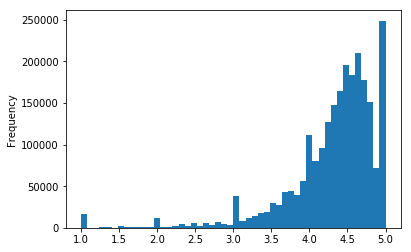

In [15]:
ax = sorted_rows["avg_rating"].plot.hist(bins = 50)

In [26]:
lds = len(dataset)


onePointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 1.5) & (sorted_rows["avg_rating"] >= 1)]
onePointFiveRatio = len(onePointFive)/lds
print(onePointFiveRatio)
two = sorted_rows.loc[(sorted_rows["avg_rating"] <= 2.0) & (sorted_rows["avg_rating"] > 1.5)]
twoRatio = len(two)/lds
print(twoRatio)
twoPointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 2.5) & (sorted_rows["avg_rating"] > 2.0)]
twoPointFiveRatio = len(twoPointFive)/lds
print(twoPointFiveRatio)
three = sorted_rows.loc[(sorted_rows["avg_rating"] <= 3.0) & (sorted_rows["avg_rating"] > 2.5)]
threeRatio = len(three)/lds
print(threeRatio)
threePointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 3.5) & (sorted_rows["avg_rating"] > 3.0)]
threePointFiveRatio = len(threePointFive)/lds
print(threePointFiveRatio)
four = sorted_rows.loc[(sorted_rows["avg_rating"] <= 4.0) & (sorted_rows["avg_rating"] > 3.5)]
fourRatio = len(four)/lds
print(fourRatio)
fourPointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 4.5) & (sorted_rows["avg_rating"] > 4.0)]
fourPointFiveRatio = len(fourPointFive)/lds
print(fourPointFiveRatio)
five = sorted_rows.loc[(sorted_rows["avg_rating"] <= 5.0) & (sorted_rows["avg_rating"] > 4.5)]
fiveRatio = len(five)/lds
print(fiveRatio)

0.008685304177854437
0.006449839088297946
0.007166441448781943
0.025591270070089142
0.03979545703352529
0.13195428118724506
0.3363355420564106
0.44402186493779555


In [50]:
badReviews = pd.read_csv(BR_DATASET) 

badReviews.head()

badReviewRatio = len(badReviews)/lds
print(badReviewRatio)

0.000356003038561146


In [51]:
def getEntries(dataset, ratio, entriesWanted):
    numEntries = math.floor(ratio*entriesWanted)
    samplingSetSize = len(dataset)
    entries = 0

    collectedRows = pd.DataFrame(columns=['entry_id', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'avg_review'])

    while (entries < numEntries):
        index = random.randint(0, samplingSetSize)

        product_id = sorted_rows.iloc[index]['product_id']
        reviews = sorted_rows.loc[sorted_rows["product_id"] == product_id]
        entries += len(reviews)

        if(len(reviews) > 0):
            print(len(reviews))

        for i in range(len(reviews)):
            collectedRows = collectedRows.append(reviews.iloc[i])

    return collectedRows

def subset(entriesWanted):
    dsOut = collectedRows = pd.DataFrame(columns=['entry_id', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'avg_review'])

    entries = getEntries(onePointFive, onePointFiveRatio, entriesWanted) #1.0 - 1.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(two, twoRatio, entriesWanted) # 1.5 - 2.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(twoPointFive, twoPointFiveRatio, entriesWanted) # 2.0 - 2.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(three, threeRatio, entriesWanted) # 2.5 - 3.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(threePointFive, threePointFiveRatio, entriesWanted) # 3.0 - 3.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(four, fourRatio, entriesWanted) # 3.5 - 4.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(fourPointFive, fourPointFiveRatio, entriesWanted) # 4.0 - 4.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(five, fiveRatio, entriesWanted) # 4.5 - 5.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])

    return dsOut

subSample = subset(ENTRIES_WANTED)
print(len(subSample))
subSample.head(25)

334
22
15
12
80
157
25
110
105
26
1
41
129
1
27
27
34
47
9
5
1
3
26
1682
2
223
45
44
18
86
6
14
17
63
72
28
8
175
2
9
531
40
23
13
69
10
57
235
77
74
374
133
301
11
16
4
197
23
76
1
6
6
190
38
37
2
1
421
2
8
20
55
5
5
129
342
457
307
2
95
242
2
111
1
6
1190
35
56
214
102
31
1
17
16
142
348
44
86
1
22
135
1
58
57
12
518
120
320
20
21
44
77
12174


,entry_id,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,avg_review,avg_rating
2200607,NaN,US,25144693,R2ZAQMGLNMEZL8,B00012182G,554396858,Fresh Whole Rabbit,Grocery,5.0,359.0,408.0,N,N,Kill the Wabbit!,"The twick is not so much to catch the wabbit, ...",2011-01-19,NaN,3.18
2294278,NaN,US,13452528,R34LEEROG8CHUQ,B00012182G,554396858,Fresh Whole Rabbit,Grocery,5.0,8.0,11.0,N,N,Perfect for those lonely nights!,It was about 4 years ago when my wife left me....,2009-08-05,NaN,3.18
1175753,NaN,US,14032846,R13WYIGFDFCXX8,B00012182G,554396858,Fresh Whole Rabbit,Grocery,5.0,1.0,1.0,N,N,Rabbit fulfills dreams and kills loved ones.,"Normally I would say that paying over 1,000 ti...",2014-06-26,NaN,3.18
2355541,NaN,US,53009262,R2TDZPMW04OMCA,B00012182G,554396858,Fresh Whole Rabbit,Grocery,5.0,125.0,160.0,N,N,What a combination,"While I'm sure the rabbit tastes fine, I have ...",2007-12-08,NaN,3.18
2293512,NaN,US,13382266,R2ACK4IYBPPNVQ,B00012182G,554396858,Fresh Whole Rabbit,Grocery,5.0,33.0,41.0,N,N,Feelin' Lucky!,This is one of the finest rabbits I've ever ha...,2009-08-11,NaN,3.18
1940302,NaN,US,16419421,R3MXCTS6BNM5HE,B00012182G,554396858,Fresh Whole Rabbit,Grocery,3.0,4.0,8.0,N,N,Not quite as good as quail for duping evangeli...,I was going to use this Fresh Whole Rabbit as ...,2012-12-07,NaN,3.18
2195187,NaN,US,14369461,R1X1GWAE7ZSSRA,B00012182G,554396858,Fresh Whole Rabbit,Grocery,4.0,7.0,10.0,N,N,Utterly Remarkable!!!,For the past three hundred and fifty one years...,2011-02-07,NaN,3.18
2022853,NaN,US,38332331,R15H46SKJH71MO,B00012182G,554396858,Fresh Whole Rabbit,Grocery,1.0,9.0,64.0,N,N,IS THIS A SICK JOKE?!?,IS THIS A SICK JOKE?! What the hell with the c...,2012-06-25,NaN,3.18
1568001,NaN,US,31903749,R1A2NKTYOL8E6L,B00012182G,554396858,Fresh Whole Rabbit,Grocery,3.0,12.0,12.0,N,N,He could have left a message...,This was a helluva way for my Doctor to tell m...,2013-10-12,NaN,3.18
2205165,NaN,US,35176486,R366H06X2PO81B,B00012182G,554396858,Fresh Whole Rabbit,Grocery,2.0,4.0,9.0,N,N,A Morbid Thought,Whoever put the picture of the cute bunnies as...,2011-01-04,NaN,3.18


In [55]:
count = 0
print(len(subSample))
for i in range(len(badReviews)):
    review_id = badReviews.iloc[i]["review_id"]
    if ((subSample['review_id'] == review_id).any() == True):
        count += 1

numBadReviews = round(badReviewRatio * ENTRIES_WANTED)
if (count < numBadReviews):
    difference = numBadReviews - count
    for i in range(difference):
        index = random.randint(0, samplingSetSize)
        subSample = subSample.append(badReviews.iloc[index])

print(len(subSample))
print(count)

12174
12174
4


In [56]:
subSample.to_csv('subSampled_Reviews.csv')